### Context
Brain Tumors are complex. There are a lot of abnormalities in the sizes and location of the brain tumor(s). This makes it really difficult for complete understanding of the nature of the tumor. Also, a professional Neurosurgeon is required for MRI analysis. Often times in developing countries the lack of skillful doctors and lack of knowledge about tumors makes it really challenging and time-consuming to generate reports from MRI’. So an automated system on Cloud can solve this problem.


### Objective 

To Detect and Classify Brain Tumor using CNN . To achieve this we will be using transfer learning mechanism; ResNet50 deep learning model.

Let us import first all the essential libraries.

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
import tensorflow as tf
from sklearn.utils import shuffle
from tqdm import tqdm
import cv2
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

The dataset library consist MRI of 3 types of brain tumor - glioma tumor, meningioma tumor, and pituitary tumor and the fourth type of MRI images are normal(no tumor). Let us import and label this images as follows-

In [80]:
label = ['glioma_tumor','meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [81]:
size = 150 
X = []
y = []
for i in label:
    path = os.path.join('F:\dataset\Brain_tumor', 'Training', i)
    for j in tqdm(os.listdir(path)):
        img = plt.imread(os.path.join(path, j))
        image = cv2.resize(img, (size, size))
        norm = np.zeros((150 , 150 ))
        image = cv2.normalize(image, norm, 0, 255, norm_type=cv2.NORM_MINMAX)
        X.append(image)
        y.append(i)

for i in label:
    path = os.path.join('F:\dataset\Brain_tumor', 'Testing', i)
    for j in tqdm(os.listdir(path)):
        img = plt.imread(os.path.join(path, j))
        image = cv2.resize(img, (size, size))
        norm = np.zeros((150 , 150))
        image = cv2.normalize(image, norm, 0, 255, norm_type=cv2.NORM_MINMAX)
        X.append(image)
        y.append(i)

100%|██████████| 74/74 [00:01<00:00, 73.93it/s]


In [82]:
X = np.array(X)
y = np.array(y)

In [83]:
print('Shape of X : ', X.shape)
print('Shape of y : ', y.shape)

Shape of X :  (3264, 150, 150, 3)
Shape of y :  (3264,)


In [84]:
X, y = shuffle(X, y, random_state=112)

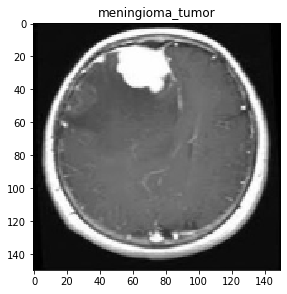

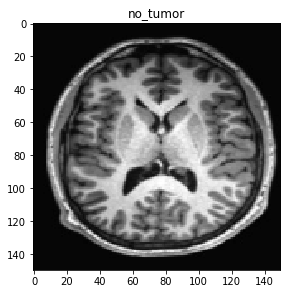

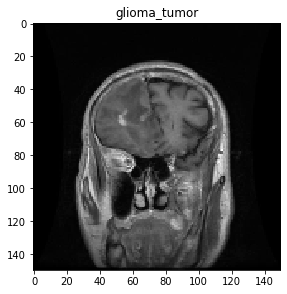

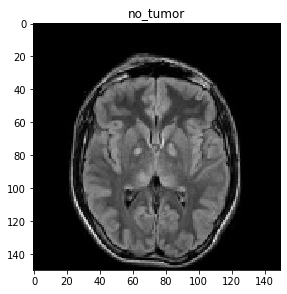

In [85]:
# Plotting images.

for i in range(4):
    plt.figure(figsize=(10, 10))
    plt.subplot(2, 2, i+1)
    plt.imshow(X[i])
    plt.title(y[i])
    plt.show()

Using ImageDataGenerator for image augmentation. ImageDataGenerator class helps us achieving our goal of image augmentation. 

In [86]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
    )

datagen.fit(X)
X.shape

(3264, 150, 150, 3)

For better classification, let us now encode the classes using one-hot encoding.
One hot encoding is method of converting categorical variables to binary vectors.

In [87]:
# One hot encoding.

y_new = []
for i in y:
    y_new.append(label.index(i))
y = y_new
y = tf.keras.utils.to_categorical(y, 4)

In [88]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.1)

In [89]:
print('Xtrain shape : ', Xtrain.shape)
print('ytrain shape : ', ytrain.shape)
print('Xtest shape : ', Xtest.shape)
print('ytest shape : ', ytest.shape)

Xtrain shape :  (2937, 150, 150, 3)
ytrain shape :  (2937, 4)
Xtest shape :  (327, 150, 150, 3)
ytest shape :  (327, 4)


### Transfer Learning 
We will be using transfer learning mechanism to trained our image classification model as training data on a new model consume lots of time. So to save time we can use transfer learning which uses weights from earlier pre-trained model.

Using ResNet50 for transfer learning-

With the increasing network depth, accuracy gets saturated and then degrades rapidly. Unexpectedly, such degradation is not caused by overfitting, and adding more layers to a suitably deep model leads to higher training error. In short deeper neural networks are difficult to train.

Deep residual network helps to overcome this issue and help us to train deeper neural network.

In ResNet50, '50' stands for the number of layers in the deep convolutional neural network, in which there are 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer. 

Let's train our model using ResNet50. We will be using weights of pre-trained model from ImageNet and freezing the output layer. Freezing prevents weights from getting modified.

In [90]:
pre_trained_model = ResNet50(input_shape = (150 , 150 , 3),
                               include_top = False,
                               weights = 'imagenet')

# Freezing the top layer.

for layer in pre_trained_model.layers:
    layer.trainable = False

In [91]:
pre_trained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

We set dropout rate=0.15 as it gave better results than the other rate used. It is an regularization technique which prevents overfitting by switching of some neurons in the layers. Rate=0.15 means 15% of the neurons will be shutdown randomly during training. Low dropout rate has minimal effect and rate too high results in under-learning by the network.

In [92]:
model = pre_trained_model.layers[-1].output
        
x = tf.keras.layers.GlobalMaxPooling2D()(model)
x = tf.keras.layers.Dropout(rate = 0.15)(x)
x = tf.keras.layers.Dense(4, activation = 'softmax')(x)

model = tf.keras.models.Model(inputs = pre_trained_model.input, outputs = x)

In [93]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [94]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ['accuracy']
             )

In [95]:
history = model.fit(Xtrain, ytrain, epochs = 15, batch_size = 32, validation_split = 0.1, verbose = 2)

Epoch 1/15
83/83 - 219s - loss: 2.7413 - accuracy: 0.5569 - val_loss: 1.1878 - val_accuracy: 0.7211
Epoch 2/15
83/83 - 192s - loss: 1.3779 - accuracy: 0.7170 - val_loss: 0.9112 - val_accuracy: 0.7993
Epoch 3/15
83/83 - 179s - loss: 0.9815 - accuracy: 0.7923 - val_loss: 0.9005 - val_accuracy: 0.7857
Epoch 4/15
83/83 - 196s - loss: 0.9537 - accuracy: 0.7949 - val_loss: 1.1866 - val_accuracy: 0.7993
Epoch 5/15
83/83 - 183s - loss: 0.6866 - accuracy: 0.8403 - val_loss: 0.8186 - val_accuracy: 0.8163
Epoch 6/15
83/83 - 179s - loss: 0.5186 - accuracy: 0.8733 - val_loss: 0.7042 - val_accuracy: 0.8367
Epoch 7/15
83/83 - 181s - loss: 0.4449 - accuracy: 0.8820 - val_loss: 0.7652 - val_accuracy: 0.8435
Epoch 8/15
83/83 - 185s - loss: 0.4048 - accuracy: 0.8941 - val_loss: 0.6849 - val_accuracy: 0.8537
Epoch 9/15
83/83 - 177s - loss: 0.3365 - accuracy: 0.8997 - val_loss: 0.6936 - val_accuracy: 0.8537
Epoch 10/15
83/83 - 221s - loss: 0.3222 - accuracy: 0.9062 - val_loss: 0.7919 - val_accuracy: 0.8299

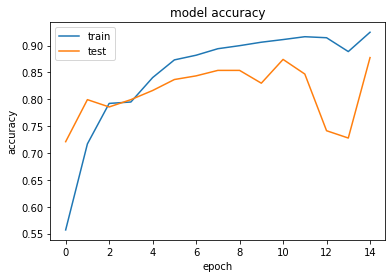

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

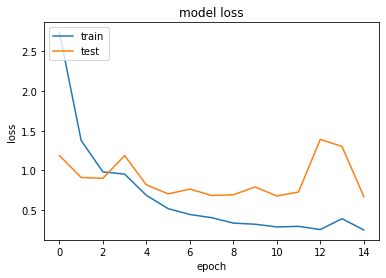

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [98]:
yhat = model.predict(Xtest)

In [99]:
y_hat = np.argmax(yhat, axis = 1)
y_test = np.argmax(ytest, axis = 1)

In [100]:
print('Accuracy :', (accuracy_score(y_test, y_hat)))
print('-------------------------------------------------')
print('Confusion matrix :\n', (confusion_matrix(y_test, y_hat)))
print('-------------------------------------------------')
print('Classification report :\n', (classification_report(y_test, y_hat)))

Accuracy : 0.8807339449541285
-------------------------------------------------
Confusion matrix :
 [[73 16  2  2]
 [ 8 82  1  5]
 [ 0  1 47  1]
 [ 1  2  0 86]]
-------------------------------------------------
Classification report :
               precision    recall  f1-score   support

           0       0.89      0.78      0.83        93
           1       0.81      0.85      0.83        96
           2       0.94      0.96      0.95        49
           3       0.91      0.97      0.94        89

    accuracy                           0.88       327
   macro avg       0.89      0.89      0.89       327
weighted avg       0.88      0.88      0.88       327



[]

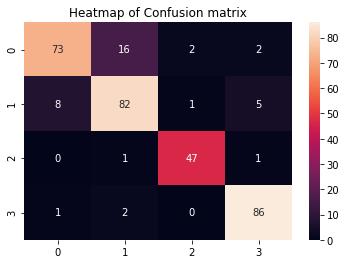

In [101]:
sns.heatmap(confusion_matrix(y_test, y_hat), annot=True)
plt.title('Heatmap of Confusion matrix')
plt.plot()

### Conclusion

Training the model for image classification for brain tumor detection using ResNet50, we get 88% accuracy on test dataset.